# Grafo: Unidades Nutricionais por rede de Fast Food 

O objetivo foi criar um grafo que representasse o nível de nutrientes presente em cada lanche das redes selecionadas (Mc Donalds, Burguer King e Starbucks).

O gráfico que aparece ano meio desse notebook contém todos os dados disponíveis no banco, portanto, está visualmente poluido e, assim, não cumpre os objetivos. Porém, as próximas etapas consistem em criar "filtros" para resolver esse problema, no final desse mesmo notebook.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Como fizemos a leitura e limpeza de dados no notebook "Dados_MYSQL", aqui só precisamos importa-los. O índice das linhas é o nome do lanche, para facilitar sua identificação:

In [2]:
df = pd.read_csv("fastfood.csv", index_col="name")

Queremos criar nodes que representem cada nutriente, de forma que o tamanho deles seja determinado pela sua quantidade contida em todos os lanches. Para tornar isso possível, somamos essas quantidades e normalizamos os dados.

In [3]:
soma_list,nutri = [],[]

for nutriente in df.columns[0:len(df.columns)-2]: #para cada nutriente no dataframe (-2 para excluir "categoria" e "rede")
    soma_list.append(df[nutriente].sum()) #soma os valores totais 
    nutri.append(nutriente) #guardamos o nome do nutriente

soma_list = pd.Series(soma_list)
  
soma_norm = (soma_list - soma_list.mean())/ soma_list.std() #normalização dos dados totais
soma_min = abs(soma_norm.min())

soma_norm = round((soma_norm + soma_min + 1)*700) #deixa todos os valores > 0 
    
soma_nutri = dict(zip(nutri,soma_norm)) #criamos um dicionário com o nutriente e sua soma total normalizada

Agora precisamos simplismente criar o grafo, os nós e as arestas.

In [4]:
fastfood = nx.Graph()  #criar o grafo

#criar os nós para cada unidade nutricional  
for nutrientes in df.columns[0:len(df.columns)-2]:
    if soma_nutri[nutrientes] >0:
        fastfood.add_node(nutrientes,color="grey",size=soma_nutri[nutrientes])
    # soma_nutri possui os dados normalizads criados anteriormente
    
# criar os nós para cada lanche    
for lanche in df.index:
    fastfood.add_node(lanche, color= df.loc[lanche,"rede"],size=700,categoria=df.loc[lanche,"categoria"]) #criando os nós de cada lanche 
     # o atributo categoria será usado futuramente para filtrar o grafo
         
        
#criar uma aresta ligando os lanches e os nós
for lanche in df.index:
    for nutriente in df.columns[0:len(df.columns)-2]:
        local = (df.copy()).dropna() # não faz sentido criar uma aresta se não temos o valor
        if local.loc[lanche,nutriente] > 0: #tbm não faz se o valor for zero
            fastfood.add_edge(lanche, nutriente, weight = local.loc[lanche,nutriente])
            # atribuimos o peso como o peso do nutriente, que foi normalizado



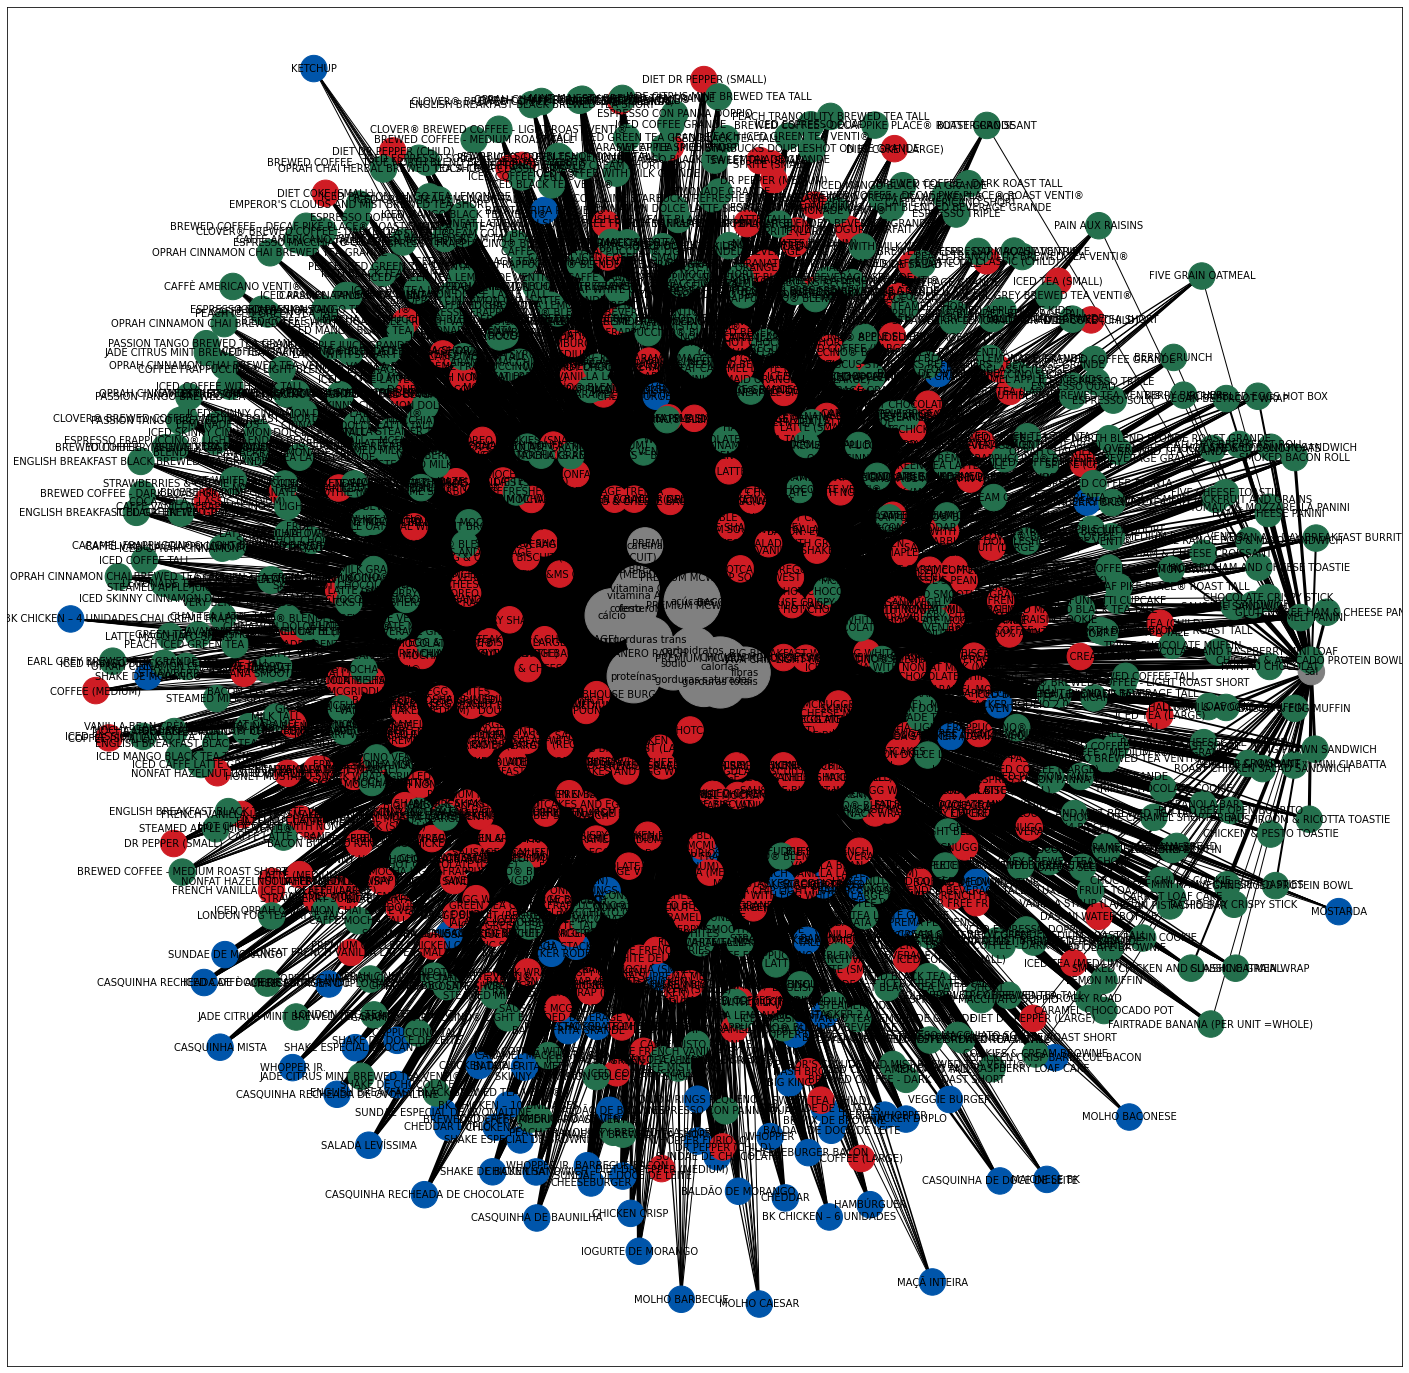

In [5]:
#plotar o grafo        
fig, ax = plt.subplots(figsize=(25,25))

pos = nx.spring_layout(fastfood) # definir as posições dos nodes
for node in fastfood.nodes:
    fastfood.nodes[node]['pos'] = list(pos[node])


nx.draw_networkx(fastfood,  #desenhar o grafo (completo)
                  arrows=True,
                  pos=pos,
                  with_labels=True,
                  ax=ax,
                  node_size=[nx.get_node_attributes(fastfood,'size')[g] for g in fastfood.nodes()], 
                  node_shape='o',
                  node_color=[nx.get_node_attributes(fastfood,'color')[g] for g in fastfood.nodes()],
                  alpha=1.0,
                  width=list(nx.get_edge_attributes(fastfood,'weight').values()),
                  style='solid',
                  font_size=10,
                  font_color='black',
                  font_weight='normal',
                  font_family='sans-serif')

Por fim, exportamos o grafo com o pickle, para que assim, possa ser utilizado em outro notebook se necessário

In [6]:
import pickle 
nx.write_gpickle(fastfood, "grafo_completo.gpickle")

#  Plotly Dash 

Com esse volume de dados, é impossível analisar, compreender e consultar o grafo criado da maneira que plotamos acima. Logo, é interessante fazer sua visualização através de uma interface, para isso utilizamos o Dash.

In [7]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output

Começamos definindo a "folha de estilo" e criando o app.

In [8]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

Essa função atribuirá as arestas os atributos que queremos, que pertencem a função "Scatter", do Plotly:

In [9]:
def make_edge(x, y, width):
    return  go.Scatter(x = x,
                       y  = y,
                       line = dict(width = width,
                                   color = "black"),
                       mode  = 'lines')

Por fim, definimos o layout da página (principalmente os botões que farão nossos filtros) e configuramos os callbacks para fazer a atualização do grafo plotado segundo as opções selecionadas.

In [22]:
# criação do título, subtítulo botões e avisos na página
app.layout = html.Div([
    html.H1(children='Fast Food Graph'), # título
    html.H4(children='''
        Visualização da tabela nutricional dos lanches em formato de grafo 
    '''), # subtítulo
    # checkboxes das redes
    html.Div([
        dcc.Checklist( 
            id='select_chain',
            options=[
                {'label': 'BURGERKING', 'value': '#0055AA'},
                {'label': 'MCDONALDS', 'value': '#CF1C24'},
                {'label': 'STARBUCKS', 'value': '#24704D'}
            ], 
            value=['#0055AA'],
            labelStyle={'display': 'inline-block'}),
    ]), 
    # dropdown dos nutrientes
    html.Label('Nutrientes'),
    dcc.Dropdown(
        id='select_nutri',
        options=[{'label': i, 'value': i} for i in df.columns[0:len(df.columns)-2]],
        value=['calorias'],
        placeholder="Selecione os nutrientes que gostaria de visualizar",
        multi=True
    ),
     # dropdown das categorias
    html.Label('Categorias'),
    dcc.Dropdown(
        id='select_categorias',
        options=[{'label': i, 'value': i} for i in list(df.categoria.unique())],
        value=['SANDUICHE DE CARNE'],
        placeholder="Selecione as categorias que gostaria de visualizar",
        multi=True
    ),
    html.Div([
        dcc.Graph(id='my-output'), 
    ]),
     # aviso 
    html.H6(children='''
        OBS: Alguns lanches não possuem informação nutricional completa e, por isso, alguns nós não são conectados
    '''),
])

# criaçao do callback, que atualiza a figura de acordo com as opções selecionadas
@app.callback(
    Output('my-output', 'figure'),
    Input('select_nutri', 'value'), #recebe os nutrientes selecionados
    Input('select_chain', 'value'), #recebe as redes selecionadas
    Input('select_categorias', 'value'), #recebe as categorias selecionadas
)
def update_output_div(sel_n, sel_c, cat): 
    edge_trace = [] 
    # itera sobre cada aresta do grafo
    for edge in fastfood.edges():
        # verifica se estão selecionadas
        if edge[0] in sel_n: 
            if df.loc[edge[1],'rede'] in sel_c:
                if df.loc[edge[1],'categoria'] in cat:
                    x0, y0 = fastfood.nodes[edge[0]]['pos']
                    x1, y1 = fastfood.nodes[edge[1]]['pos']
                    # atribui e adicona os atributos no modelo plotly
                    trace  = make_edge([x0, x1, None], [y0, y1, None], width = fastfood.get_edge_data(edge[0],edge[1])['weight'])
                    edge_trace.append(trace)

    #define os atributos dos nodes                
    node_trace = go.Scatter(x         = [],
                            y         = [],
                            text= [],
                            textposition = "top center",
                            textfont_size = 10,
                            mode      = 'markers',
                            hoverinfo = 'text',
                            marker    = dict(color = [],
                                             size  = [],
                                             line  = None))

    # itera sobre cada nó do grafo
    for node in fastfood.nodes():
        if fastfood.nodes[node]['color']=='grey':
            # verifica se estão selecionados
            if node in sel_n:
                x, y = pos[node]
                node_trace['x'] += tuple([x])
                node_trace['y'] += tuple([y])
                node_trace['marker']['color'] += tuple([fastfood.nodes[node]['color']])
                node_trace['marker']['size'] += tuple([fastfood.nodes[node]['size']/100])
                node_trace['text'] += tuple([node])
        else:
            # verifica se estão selecionadas
            if fastfood.nodes[node]['color'] in sel_c:
                if fastfood.nodes[node]['categoria'] in cat:
                    x, y = pos[node]
                    node_trace['x'] += tuple([x])
                    node_trace['y'] += tuple([y])
                    node_trace['marker']['color'] += tuple([fastfood.nodes[node]['color']])
                    node_trace['marker']['size'] += tuple([fastfood.nodes[node]['size']/50])
                    node_trace['text'] += tuple([node])

    # define o layout da página
    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)', 
        xaxis =  {'showgrid': False, 'zeroline': False}, 
        yaxis = {'showgrid': False, 'zeroline': False}, 
        width=1000, 
        height=750 
    )


    fig = go.Figure(layout = layout)


    # adicona os elementos na figura 
    for trace in edge_trace:
        fig.add_trace(trace)
    
    fig.add_trace(node_trace)
    
    fig.update_layout(showlegend = False)
    
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)

    
    return fig
    
if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/
